In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
import timeit


# New section - Data preprocess

In [2]:
df_pv = pd.read_csv('solar_panel_power.csv', index_col=0, parse_dates=['datetime'])
df_pv

,datetime,power
0,2020-01-01 00:00:00,0.0
1,2020-01-01 00:30:00,0.0
2,2020-01-01 01:00:00,0.0
3,2020-01-01 01:30:00,0.0
4,2020-01-01 02:00:00,0.0
...,...,...
4267,2020-03-29 21:30:00,0.0
4268,2020-03-29 22:00:00,0.0
4269,2020-03-29 22:30:00,0.0
4270,2020-03-29 23:00:00,0.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

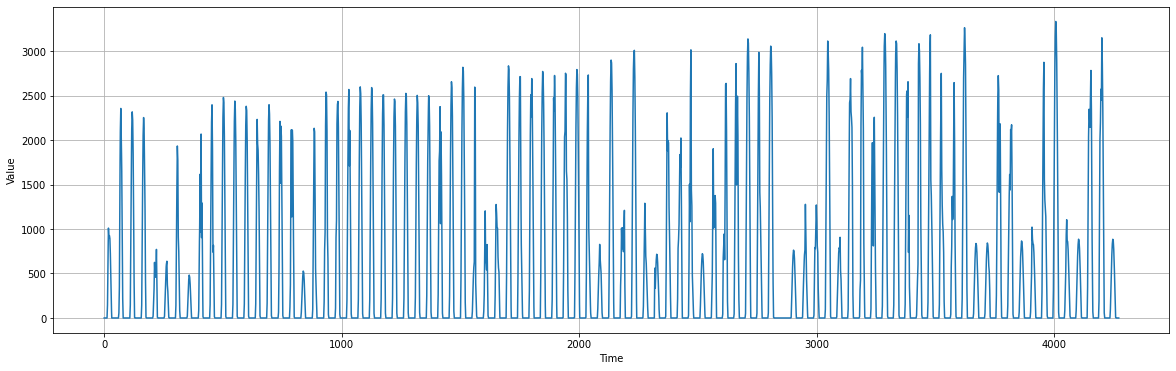

In [4]:
plt.figure(figsize=(20,6))
plot_series(df_pv.index, df_pv['power'])
plt.show()

In [5]:
df = df_pv.set_index("datetime")
print(df.head(5))
df.isnull().sum().sum()

                     power
datetime                  
2020-01-01 00:00:00    0.0
2020-01-01 00:30:00    0.0
2020-01-01 01:00:00    0.0
2020-01-01 01:30:00    0.0
2020-01-01 02:00:00    0.0


0

In [6]:
def add_datetime(datasets):
    datasets.index = pd.to_datetime(datasets.index)
    datasets['year'] = datasets.index.year
    datasets['month'] = datasets.index.month
    datasets['week'] = datasets.index.week
    datasets['day'] = datasets.index.day
    datasets['hour'] = datasets.index.hour
    datasets['minute'] = datasets.index.minute
    datasets['dayofweek'] = datasets.index.dayofweek
    return datasets

In [7]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
def create_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# load dataset
datasets = add_datetime(df)
values = datasets.values
# integer encode direction
encoder = LabelEncoder()
values[:,-1] = encoder.fit_transform(values[:,-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = create_dataset(scaled, 1, 1)
reframed.head()
# # drop columns we don't want to predict
reframed.drop(reframed.columns[list(range(len(datasets.columns)+1, 2*len(datasets.columns)))], axis=1, inplace=True)
print(reframed.head)

<bound method NDFrame.head of       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1           0.0        0.0        0.0        0.0   0.000000   0.000000   
2           0.0        0.0        0.0        0.0   0.000000   0.000000   
3           0.0        0.0        0.0        0.0   0.000000   0.043478   
4           0.0        0.0        0.0        0.0   0.000000   0.043478   
5           0.0        0.0        0.0        0.0   0.000000   0.086957   
...         ...        ...        ...        ...        ...        ...   
4267        0.0        0.0        1.0        1.0   0.933333   0.913043   
4268        0.0        0.0        1.0        1.0   0.933333   0.913043   
4269        0.0        0.0        1.0        1.0   0.933333   0.956522   
4270        0.0        0.0        1.0        1.0   0.933333   0.956522   
4271        0.0        0.0        1.0        1.0   0.933333   1.000000   

      var7(t-1)  var8(t-1)  var1(t)  
1           0.0   0.333333      0.0  
2    

C:\Users\maury\AppData\Local\Temp/ipykernel_35196/239155171.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  datasets['week'] = datasets.index.week


In [11]:
# train_ratio = 0.8
test_len = 334
values = reframed.values
train_data = len(values) - test_len
print(train_data)

timesteps = 1
train = values[:train_data, :]
test = values[train_data:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timesteps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], timesteps, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

3937
(3937, 1, 8) (3937,) (334, 1, 8) (334,)


In [12]:
print('X_train.shape = ',train_X.shape)
print('y_train.shape = ', train_y.shape)
print('X_test.shape = ', test_X.shape)
print('y_test.shape = ',test_y.shape)

X_train.shape =  (3937, 1, 8)
y_train.shape =  (3937,)
X_test.shape =  (334, 1, 8)
y_test.shape =  (334,)


In [13]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power')
    plt.plot(predicted, alpha=0.7, color='green',label='Predicted power')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power scale')
    plt.legend()
    plt.show()

# RNN Model

In [14]:
# Build Simple RNN 
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 40)             1960      
_________________________________________________________________
dropout (Dropout)            (None, 1, 40)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 40)             3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 40)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [15]:
start_training_time = timeit.default_timer()
rnn_model.compile(optimizer="adam",loss="MSE", metrics=['mean_squared_error'])
rnn_model.fit(train_X, train_y, epochs=30, batch_size=1000)
stop_training_time = round((timeit.default_timer() - start_training_time))
print('Training Time: ', stop_training_time)

Epoch 1/30
4/4 [==============================] - 10s 23ms/step - loss: 0.1749 - mean_squared_error: 0.1749
Epoch 2/30
4/4 [==============================] - 0s 19ms/step - loss: 0.1203 - mean_squared_error: 0.1203
Epoch 3/30
4/4 [==============================] - 0s 22ms/step - loss: 0.0979 - mean_squared_error: 0.0979
Epoch 4/30
4/4 [==============================] - 0s 20ms/step - loss: 0.0758 - mean_squared_error: 0.0758
Epoch 5/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0725 - mean_squared_error: 0.0725
Epoch 6/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 7/30
4/4 [==============================] - 0s 21ms/step - loss: 0.0507 - mean_squared_error: 0.0507
Epoch 8/30
4/4 [==============================] - 0s 21ms/step - loss: 0.0471 - mean_squared_error: 0.0471
Epoch 9/30
4/4 [==============================] - 0s 25ms/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 10/30
4/4 [===================

In [16]:
rnn_predictions = rnn_model.predict(test_X)

rnn_score = r2_score(test_y,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9558956268081023


In [17]:
rnntrainScore = rnn_model.evaluate(train_X, train_y, verbose=0)
print('Train loss:', rnntrainScore[0]) 
print('Train accuracy:', rnntrainScore[1])

Train loss: 0.0031769603956490755
Train accuracy: 0.0031769603956490755


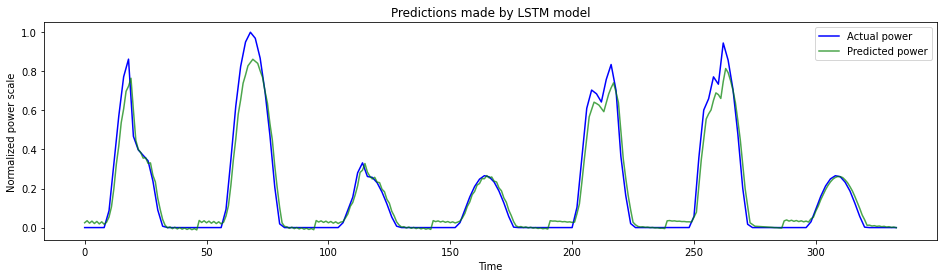

In [18]:
plot_predictions(test_y, rnn_predictions, "Predictions made by LSTM model")